In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from tqdm import tqdm
import random

NAME = "Eyes-Testing"

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

# TrainDIR="D:\\TamerProject\\OCT2017\\train"
TrainDIR="D:\\TamerProject\\OCT2017\\Full"
TestDIR="D:\\TamerProject\\OCT2017\\test"


CATEGORIES=["NORMAL","DRUSEN","CNV","DME"]
print("Init OK")


Init OK


In [17]:
#Load all images and caption
image_path_to_caption = collections.defaultdict(list)

for category in CATEGORIES:
    path = os.path.join(TrainDIR,category) 
    caption = f"<start> "+category+" <end>"
    
    for img in tqdm(os.listdir(path)):  
            try:
                image_path = path + '\\'+ img
                image_path_to_caption[image_path].append(caption)
#                 print('\n image_path='+image_path+'\n')
#                 print('\n caption ='+caption+'\n')
            except Exception as e:  # in the interest in keeping the output clean...
                pass
print("files loading OK")

100%|████████████████████████████████████████████████████████████████████████| 11348/11348 [00:00<00:00, 711230.41it/s]

files loading OK


83484
<start> CNV <end>


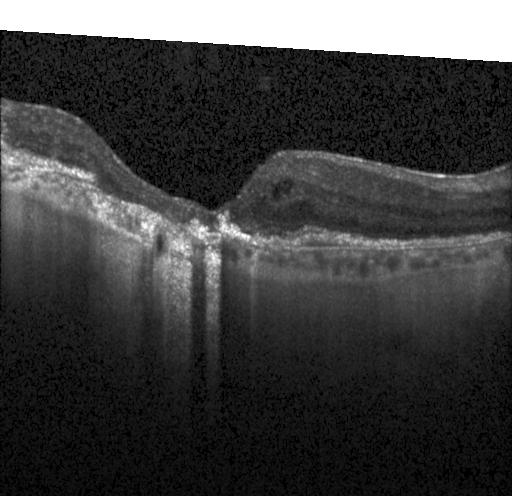

In [18]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
#train_image_paths = image_paths[:6000]
train_image_paths = image_paths
print(len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_name_vector[0])

In [19]:
#Preprocess the images using InceptionV3

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Initialize InceptionV3 and load the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████| 5218/5218 [2:13:20<00:00,  1.53s/it]


In [20]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [21]:
#Split the data into training and testing
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


#len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

print("\nTraining set images: ",len(cap_train))
print("\ntesting set images: ",len(cap_val))



Training set images:  66787

testing set images:  16697


In [22]:
#Create a tf.data dataset for training

# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
#Model
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

# Run
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [24]:
#Checkpoint
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [25]:
#Start training 
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [26]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

Epoch 8 Batch 0 Loss 3.1136
Epoch 8 Batch 100 Loss 0.1094
Epoch 8 Batch 200 Loss 0.0757
Epoch 8 Batch 300 Loss 0.1084
Epoch 8 Batch 400 Loss 0.0827
Epoch 8 Batch 500 Loss 0.1085
Epoch 8 Batch 600 Loss 0.0910
Epoch 8 Batch 700 Loss 0.0763
Epoch 8 Batch 800 Loss 0.1175
Epoch 8 Batch 900 Loss 0.1045
Epoch 8 Batch 1000 Loss 0.0765
Epoch 8 Loss 0.129448
Time taken for 1 epoch 2668.86 sec

Epoch 9 Batch 0 Loss 0.1193
Epoch 9 Batch 100 Loss 0.1146
Epoch 9 Batch 200 Loss 0.0568
Epoch 9 Batch 300 Loss 0.0865
Epoch 9 Batch 400 Loss 0.0753
Epoch 9 Batch 500 Loss 0.1108
Epoch 9 Batch 600 Loss 0.0631
Epoch 9 Batch 700 Loss 0.1107
Epoch 9 Batch 800 Loss 0.1055
Epoch 9 Batch 900 Loss 0.0540
Epoch 9 Batch 1000 Loss 0.0900
Epoch 9 Loss 0.091250
Time taken for 1 epoch 1662.57 sec

Epoch 10 Batch 0 Loss 0.0577
Epoch 10 Batch 100 Loss 0.0335
Epoch 10 Batch 200 Loss 0.0912
Epoch 10 Batch 300 Loss 0.0661
Epoch 10 Batch 400 Loss 0.0396
Epoch 10 Batch 500 Loss 0.0938
Epoch 10 Batch 600 Loss 0.0762
Epoch 10 Ba

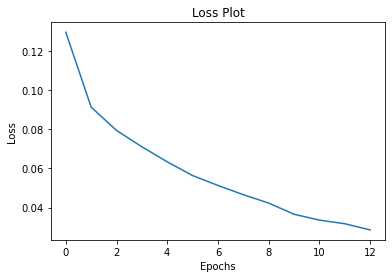

In [27]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')
    
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [28]:
image_features_extract_model.save("aftermodel.h5")

In [29]:
#evaluate
# 
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

# # captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i]
#                         for i in cap_val[rid] if i not in [0]])
# result, attention_plot = evaluate(image)

# print('Real Caption:', real_caption[8:len(result)-5])
# print('Prediction Caption:', ' '.join(result[:len(result)-5]))
# plot_attention(image, result, attention_plot)

In [30]:
#testing
rid=0
tCorrect=0
tLoss=0
for image in img_name_val:
    real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)
    RealClass=real_caption[8:len(result)-8].strip()
    PreClass=' '.join(result)
    PreClass=PreClass[:len(result)-8].strip()
#     print("RealClass="+ RealClass)
#     print("PreClass="+PreClass)
    rid=rid+1
    if (rid%50==0):
        print(rid,end=''),print("->",end=''),
    
    if (RealClass==PreClass):
        tCorrect=tCorrect+1
    else:
        tLoss=tLoss+1 
#     break

print("Total cases:",rid)
print("Correct cases:",tCorrect)
print("loss cases:",tLoss)
print(" ")
print("Correct rate =",tCorrect/rid )
print("Loss rate =", tLoss/rid)


50->100->150->200->250->300->350->400->450->500->550->600->650->700->750->800->850->900->950->1000->1050->1100->1150->1200->1250->1300->1350->1400->1450->1500->1550->1600->1650->1700->1750->1800->1850->1900->1950->2000->2050->2100->2150->2200->2250->2300->2350->2400->2450->2500->2550->2600->2650->2700->2750->2800->2850->2900->2950->3000->3050->3100->3150->3200->3250->3300->3350->3400->3450->3500->3550->3600->3650->3700->3750->3800->3850->3900->3950->4000->4050->4100->4150->4200->4250->4300->4350->4400->4450->4500->4550->4600->4650->4700->4750->4800->4850->4900->4950->5000->5050->5100->5150->5200->5250->5300->5350->5400->5450->5500->5550->5600->5650->5700->5750->5800->5850->5900->5950->6000->6050->6100->6150->6200->6250->6300->6350->6400->6450->6500->6550->6600->6650->6700->6750->6800->6850->6900->6950->7000->7050->7100->7150->7200->7250->7300->7350->7400->7450->7500->7550->7600->7650->7700->7750->7800->7850->7900->7950->8000->8050->8100->8150->8200->8250->8300->8350->8400->8450->8500->

image_path C:\Users\Alex\.keras\datasets\image.jpg
Prediction Caption: dme <end>


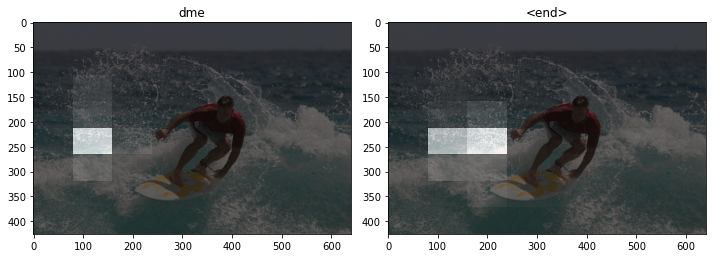

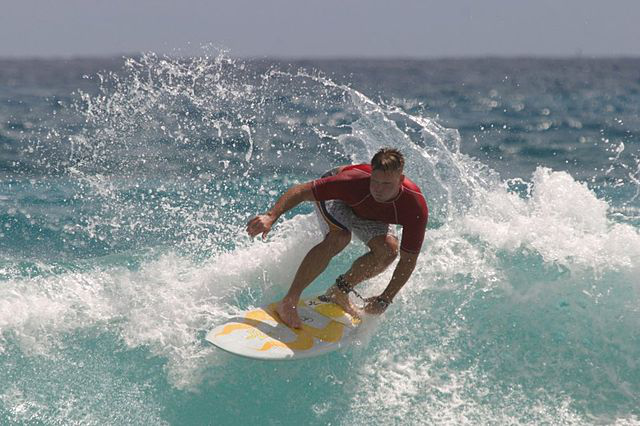

In [105]:
#prediction
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print("image_path",image_path)
result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [32]:
#Delete npy files
# TrainDIR="D:\\TamerProject\\OCT2017\\train"
TrainDIR="D:\\TamerProject\\OCT2017\\Full"
TestDIR="D:\\TamerProject\\OCT2017\\test"

import os

CATEGORIES=["NORMAL","DRUSEN","CNV","DME"]

for category in CATEGORIES:
    path = os.path.join(TrainDIR,category)

    for img in os.listdir(path) :  
            try:
                image_path = path + '\\'+ img
                image_path_Ext =img[len(img)-3:]
                 
                if (image_path_Ext=='npy'): 
                    
                    os.remove(image_path)
            except Exception as e:  # in the interest in keeping the output clean...
                pass
print('Delete done!')
            




Delete done!
